# 2nd Order Problems
Consider the computational domain $\Omega = [0,L] \times [0,B]$ and the Diffusion-Convection equation with ho-mogeneous right hand side:

$$
\newcommand{\part}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\vec}[2]{\begin{pmatrix} #1\\ #2 \end{pmatrix}}
\begin{split}
-\nabla \cdot (K\nabla u ) + \beta \cdot \nabla u & = 0\text{, in $\Omega$} \\
\part{u}{y}(x,0) & = 0 \text{, x } \in [0,L] \\
\part{u}{y}(x,B) & = 0 \text{, x } \in [0,L] \\
u(0,y) & = 0 \text{, y } \in [0,B] \\
u(L,y) & = 1 \text{, y } \in [0,B]
\end{split}
$$

The parameter $K$ is the scalar diffusion coefficient and $\beta = \vec{\beta_1}{\beta_2}$ the convection velocity field.

* **(1) Continous variational formulation**

The continuous variational formulation is: "find u $\in H_{Dg}^{1}(\Omega)$ such that $\int_{\Omega}(\nabla v\cdot (K\nabla u)+v\beta\cdot u)\, d\Omega = a(u,v) = l(v) = \int_{\Omega} f v\, d\Omega$ for all $v \in H_{D0}^{1}$."

Observation: the general term of the linear form of second order ellipitic problems is:

$$
l(v) = \int_{\Omega} f v d\Omega + \int_{\Gamma}(v \textbf{n}\cdot (K\nabla u))d\Gamma
$$

However, we have that $\int_{\partial\Omega}(v \textbf{n}\cdot (K\nabla u))d\Gamma$ is null because on $\Gamma_{N}$ it values 0 as a boundary condition, and on $\Gamma_{D}$ we put 0 because the test function is 0 on Dirichlet boundary.

* **(2) Discrete variational formulation**

The discrete variational formulation is: "find u $\in P_{kg}(\Omega)$ such that $\int_{\Omega}(\nabla v\cdot (K\nabla u)+v\beta\cdot u) d\Omega = a(u,v) = l(v) = \int_{\Omega} f v \, d\Omega$ for all $v \in P_{k0}$."

$P_{kg} = \{v \in P_k, v = g \text{ on } \Gamma_{D}\}$, and $P_k \in H^1$.

In our case, we have $f = 0$.

In [1]:
## Importing libraries

from fenics import *
from mshr import *
import numpy
from datetime import datetime
import csv
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

### User defined parameters
#### Set the following parameters according to your problem

In [2]:
def advection_diffusion(beta, 
                        k,
                        order,
                        mesh_refinement,
                        space_dim = 2,
                        L = 1.0,
                        B = 1.0,
                        r_border_refinements = 0,
                        fileio = 'pvd',
                        dir_ = './results',
                        do_plot = False
                       ):
 
    if not os.path.exists(dir_):
        os.mkdir(dir_)

    if(space_dim == 2):
       domain = Rectangle(Point(0.0,0.0), Point(L,B))
    else:
       sys.exit("space_dim.eq.3 not implemented")
       
    # Calculo da camada limite para o refinamento
    L_hcamadalimite = L - k/np.sqrt(beta[0]^2+beta[1]^2)

    # Thermal conductivity
    #k = 1.0
    kappa = Constant(k)

    # Convection velocity field
    beta = Constant(beta)

    #### IO setup
    Pk = FiniteElement("Lagrange", 'triangle', order)

    ufile_pvd  = File(dir_+f'/temperatureO{order}mr{mesh_refinement}br{r_border_refinements}.pvd')
    domfile_pvd = File(dir_+f"/auxfuncO{order}mr{mesh_refinement}br{r_border_refinements}.pvd")

    # Order of finite elements space
    startTime = datetime.now()
    print(f'\n   ::> Begin computations for order {order} and refinement {mesh_refinement}')

    #### Mesh generation
    mesh = generate_mesh(domain, mesh_refinement)
    
        
    ### Dirichlet boundary conditions
    class Left(SubDomain):
        def inside(self, x, on_boundary):
            return (on_boundary and near(x[0],0))
    class Right(SubDomain):
        def inside(self, x, on_boundary):
            return (on_boundary and near(x[0],L))

    left    = Left()
    right   = Right()

    if r_border_refinements > 0:
      for i in range(r_border_refinements):
        cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
        cell_markers.set_all(False)
        for cell in cells(mesh):
          vts = cell.get_vertex_coordinates()
          max_x = max(vts[0],vts[2],vts[4])
          if(max_x>=(L_hcamadalimite)):
            cell_markers[cell] = True
        mesh = refine(mesh, cell_markers)
    
    print("    |-Mesh done")
    print("    |--Number of vertices = "+str(mesh.num_vertices()))
    print("    |--Number of cells = "+str(mesh.num_cells()))
    print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

    
    # Finite element space
    W = FunctionSpace(mesh, Pk)
    print("    |--Total number of unknowns = %d" % (W.dim()))
    
    
    ### Variational formulation: Poisson problem
    u = TrialFunction(W)
    v = TestFunction(W)

    funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
    dx = Measure("dx")(subdomain_data=funcdom)

    f = Constant(0)
    a = inner(kappa*grad(u), grad(v))*dx + v*inner(beta,grad(u))*dx
    LL = f*v*dx


    bcleft  = DirichletBC(W, Constant(0), left)
    bcright = DirichletBC(W, Constant(1), right)

    
    ### Solution
    w = Function(W)

    # solver.solve()
    solve(a == LL, w, [bcleft, bcright])

    ####### IO
    ufile_pvd << w
    domfile_pvd << funcdom
    
    if do_plot:
        plt.figure(figsize=(10,10))
        plot(mesh,linewidth=.1)
        c = plot(w, wireframe=True, title=f'Solution')
        plt.colorbar(c)
        plt.show()
    
    return w, mesh

### Solutions for $\kappa \in {10,1,.1,.01,.001}$


   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 32099
    |--Number of cells = 63428
    |--Cell size hmax,hmin = 0.0126 0.00637
    |--Total number of unknowns = 286579

   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 32099
    |--Number of cells = 63428
    |--Cell size hmax,hmin = 0.0126 0.00637
    |--Total number of unknowns = 286579

   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 32099
    |--Number of cells = 63428
    |--Cell size hmax,hmin = 0.0126 0.00637
    |--Total number of unknowns = 286579

   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 32099
    |--Number of cells = 63428
    |--Cell size hmax,hmin = 0.0126 0.00637
    |--Total number of unknowns = 286579

   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 32

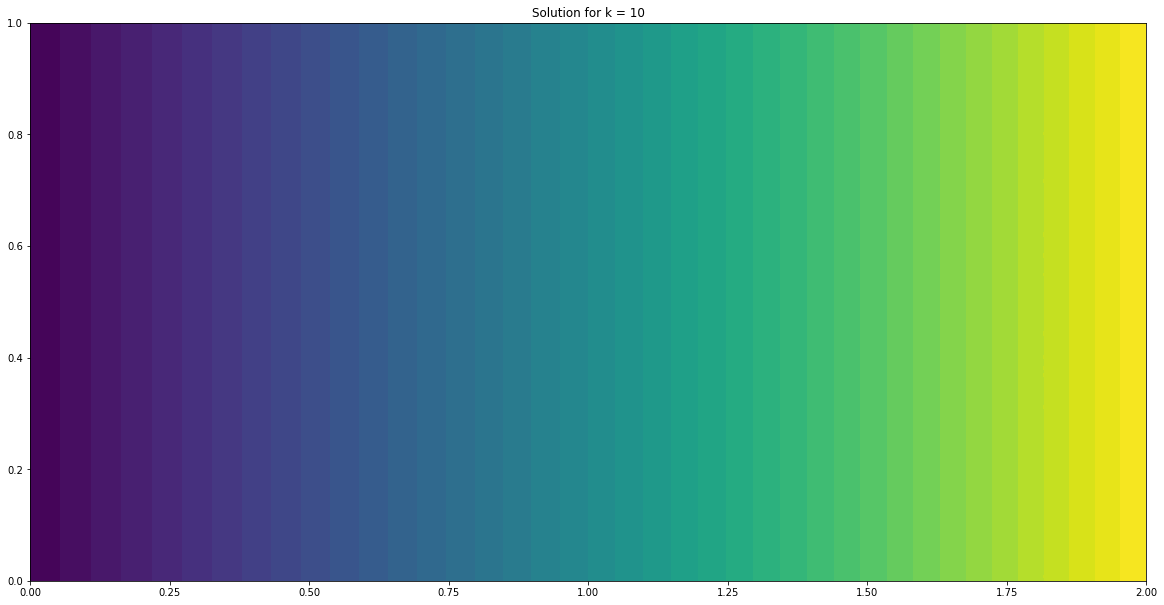

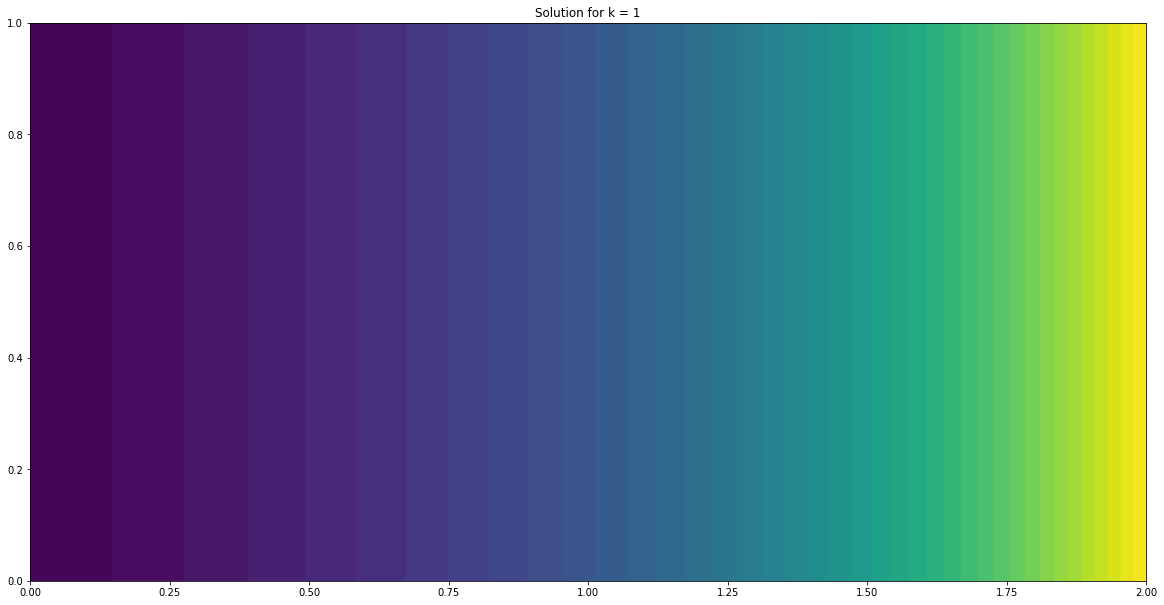

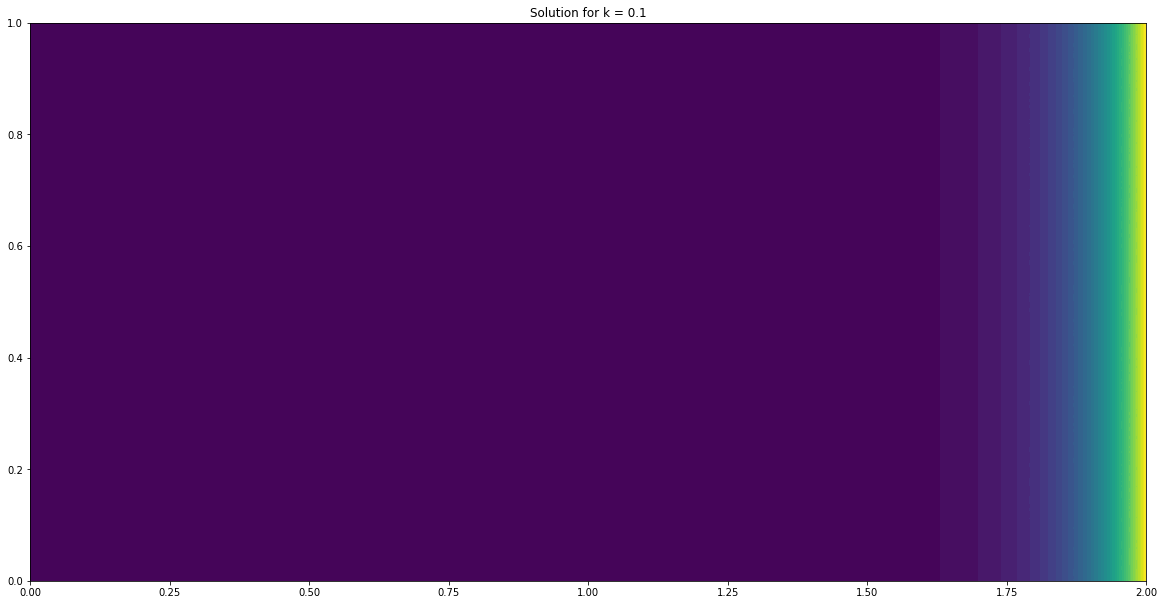

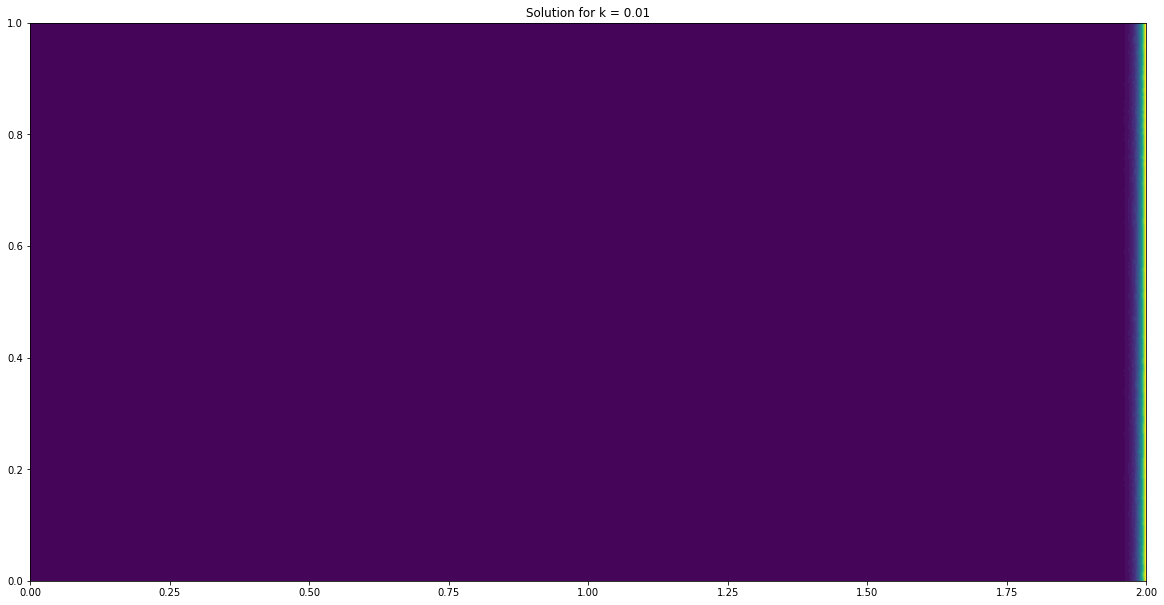

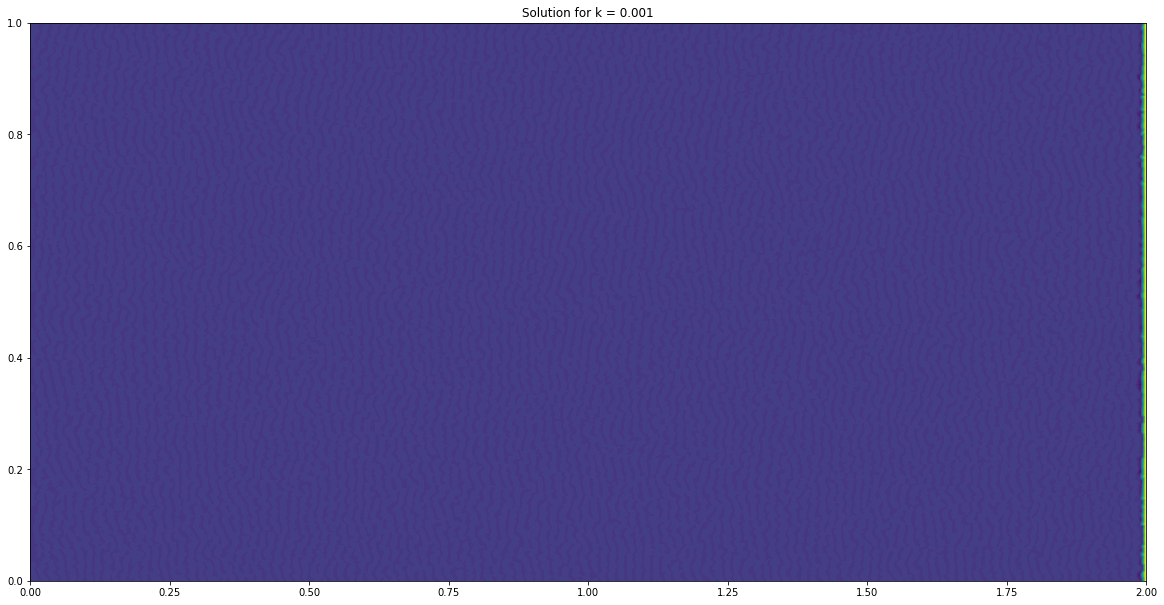

In [17]:
ks = [10, 1, .1, .01, .001]
solutions = [advection_diffusion(beta = (1,0), k = k, order = 3, mesh_refinement = 160, L = 2) 
             for k in ks]

for ((w, mesh), k) in zip(solutions, ks):
    plt.figure(figsize=(20,20))
    #plot(mesh,linewidth=.1)
    c = plot(w, wireframe=True, title=f"Solution for k = {k}")
    #plt.colorbar(c)
    plt.show()

### Uniform mesh refinements for $\kappa = .01$


   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 2063
    |--Number of cells = 3932
    |--Cell size hmax,hmin = 0.0503 0.0262
    |--Total number of unknowns = 17983

   ::> Begin computations for order 3 and refinement 80
    |-Mesh done
    |--Number of vertices = 8131
    |--Number of cells = 15876
    |--Cell size hmax,hmin = 0.0252 0.0129
    |--Total number of unknowns = 72019

   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 32099
    |--Number of cells = 63428
    |--Cell size hmax,hmin = 0.0126 0.00637
    |--Total number of unknowns = 286579

   ::> Begin computations for order 3 and refinement 320
    |-Mesh done
    |--Number of vertices = 127460
    |--Number of cells = 253382
    |--Cell size hmax,hmin = 0.00629 0.00319
    |--Total number of unknowns = 1142524


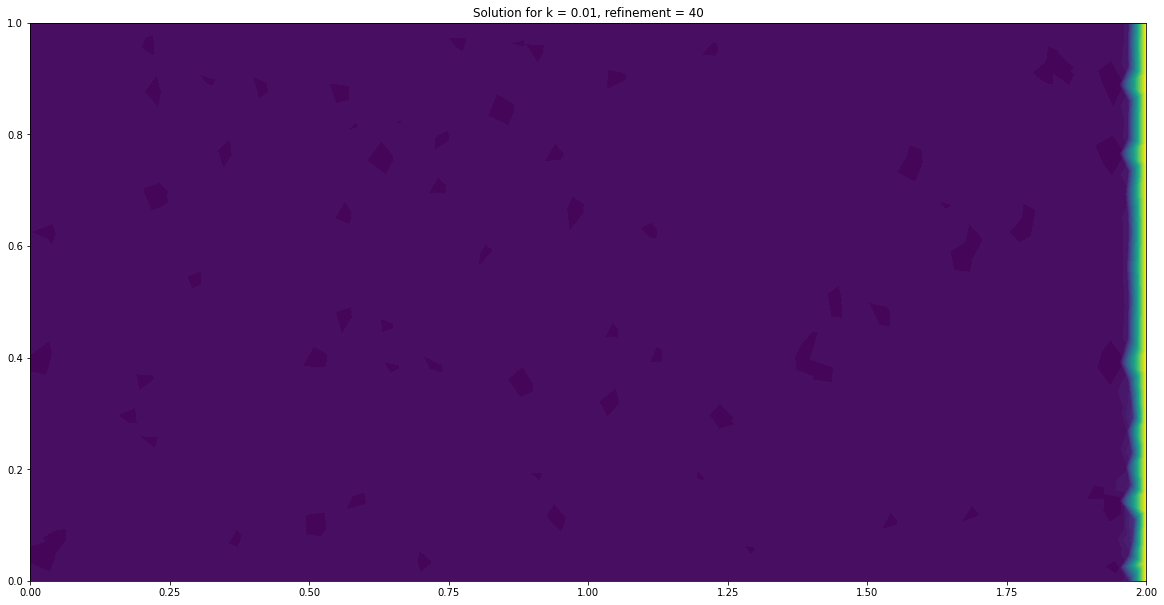

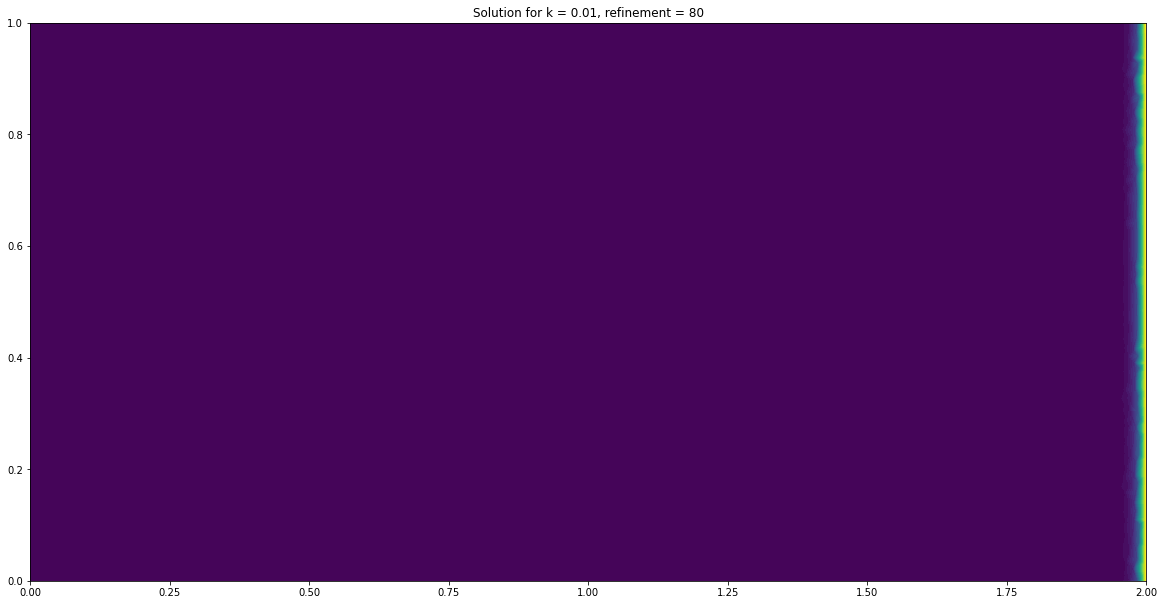

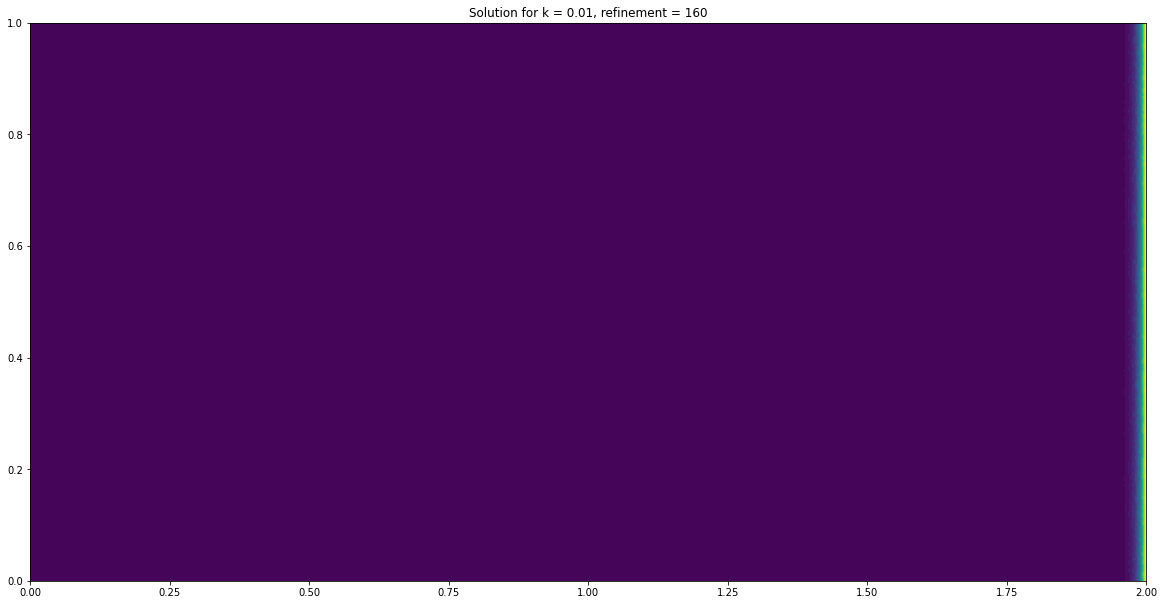

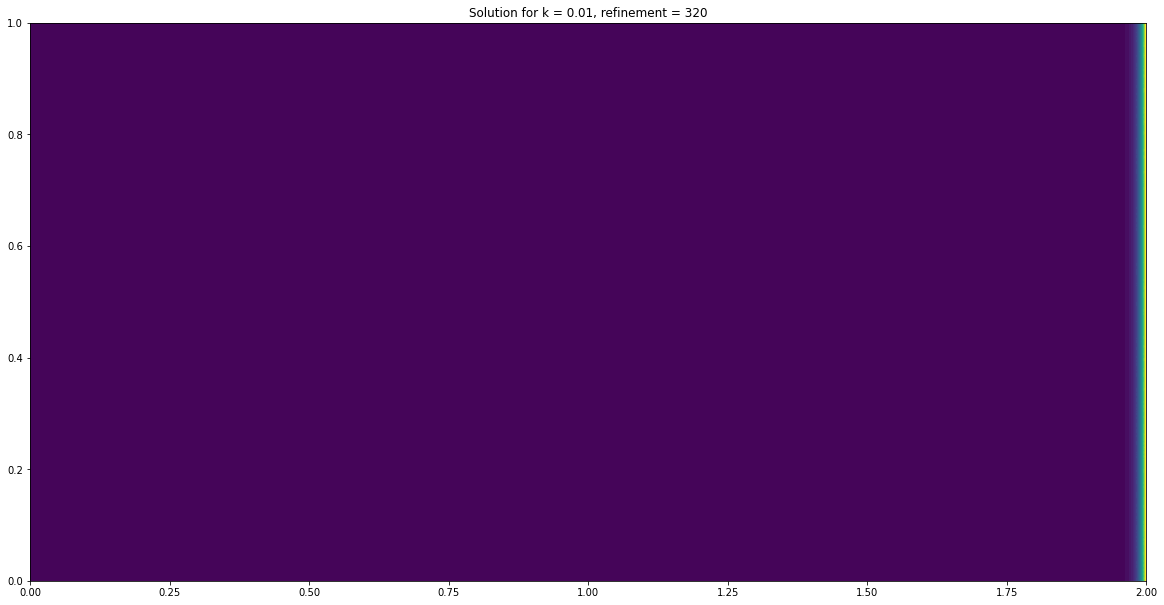

In [4]:
k = .01
refinements = [40, 80, 160, 320]

solutions = [advection_diffusion(beta = (1,0), k = k, order = 3, mesh_refinement = mesh_refinement, L = 2) 
             for mesh_refinement in refinements]

for ((w, mesh), mr) in zip(solutions, refinements):
    plt.figure(figsize=(20,20))
    #plot(mesh,linewidth=.1)
    c = plot(w, wireframe=True, title=f'Solution for k = {k}, refinement = {mr}')
    #plt.colorbar(c)
    plt.show()

### Local mesh refinement on rightmost boundary, takin $\kappa = .01$
First, so we have an idea on where the local refinement is happening, using global refinement of 40 and 4 local refinements


   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 6379
    |--Number of cells = 12067
    |--Cell size hmax,hmin = 0.0503 0.00195
    |--Total number of unknowns = 55336


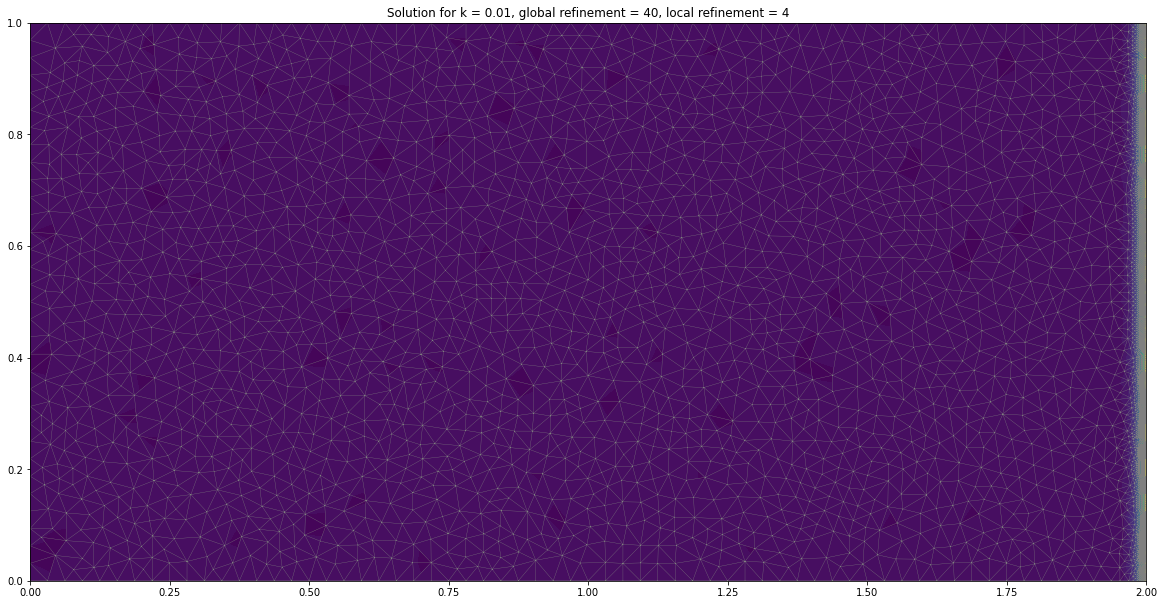

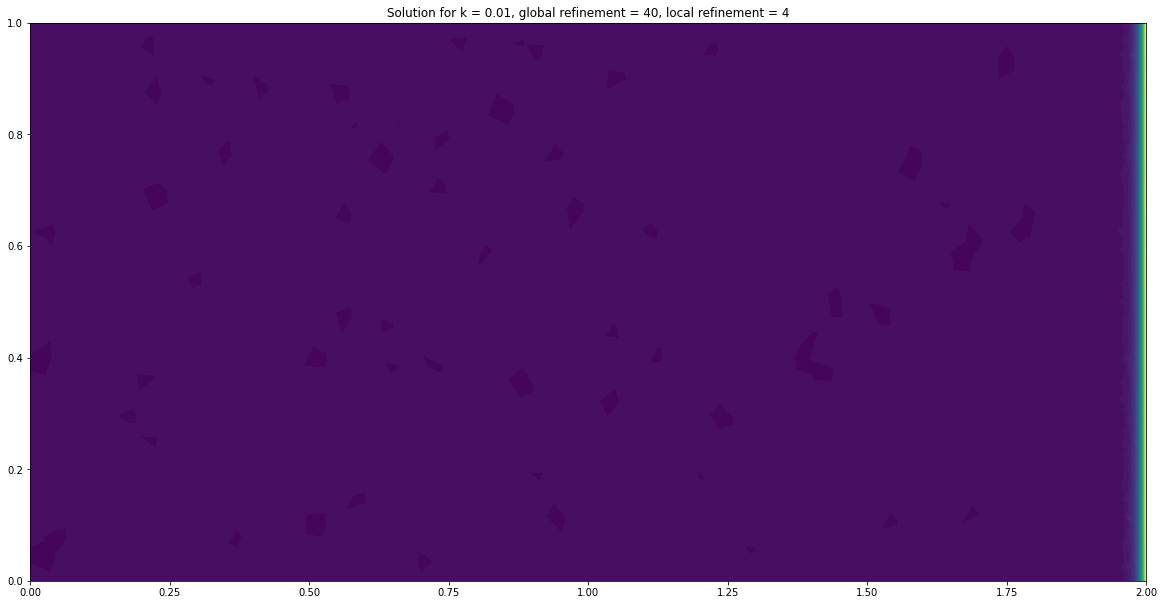

In [12]:
k = .01
(w, mesh) = advection_diffusion(beta = (1,0), 
                                k = k, 
                                order = 3, 
                                mesh_refinement = 40, 
                                L = 2, 
                                r_border_refinements = 4) 

plt.figure(figsize=(20,20))
plot(mesh,linewidth=.3)
c = plot(w, wireframe=True, title=f'Solution for k = {k}, global refinement = {40}, local refinement = {4}')
#plt.colorbar(c)
plt.show()

plt.figure(figsize=(20,20))
#plot(mesh,linewidth=.3)
c = plot(w, wireframe=True, title=f'Solution for k = {k}, global refinement = {40}, local refinement = {4}')
#plt.colorbar(c)
plt.show()


   ::> Begin computations for order 3 and refinement 80
    |-Mesh done
    |--Number of vertices = 22003
    |--Number of cells = 42631
    |--Cell size hmax,hmin = 0.0252 0.000888
    |--Total number of unknowns = 193900


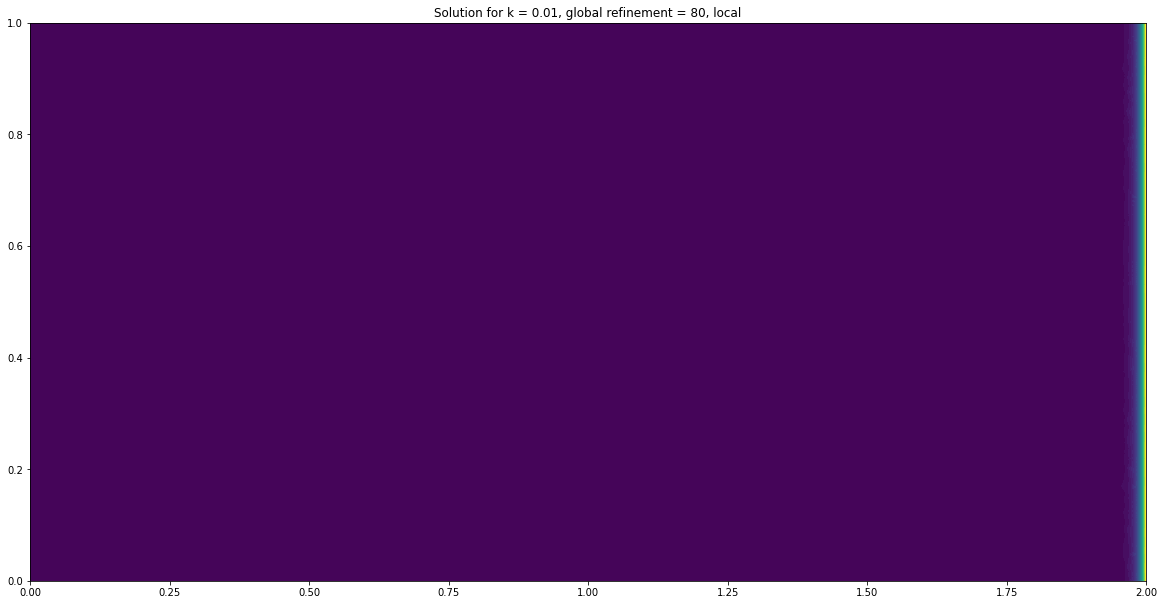

In [5]:
k = .01
(w, mesh) = advection_diffusion(beta = (1,0), 
                                k = k, 
                                order = 3, 
                                mesh_refinement = 80, 
                                L = 2, 
                                r_border_refinements = 4) 

plt.figure(figsize=(20,20))
#plot(mesh,linewidth=.1)
c = plot(w, wireframe=True, title=f'Solution for k = {k}, global refinement = {80}, local refinement = {4}')
#plt.colorbar(c)
plt.show()

### $\kappa = .001$, global mesh refinement = 160, local refinement = 4


   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 43946
    |--Number of cells = 85190
    |--Cell size hmax,hmin = 0.0126 0.000476
    |--Total number of unknowns = 387406


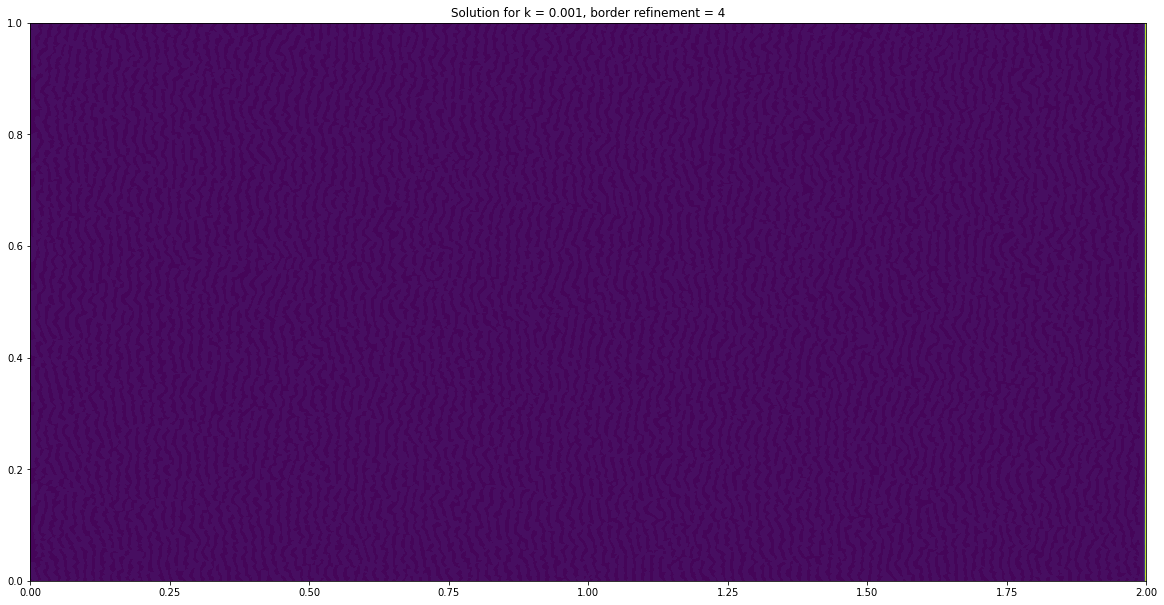

In [14]:
k = .001
r_border_refinements = 4

(w, mesh) = advection_diffusion(beta = (1,0), 
                                k = k, 
                                order = 3, 
                                mesh_refinement = 160, 
                                L = 2, 
                                r_border_refinements = r_border_refinements) 

plt.figure(figsize=(20,20))
#plot(mesh,linewidth=.1)
c = plot(w, wireframe=True, title=f'Solution for k = {k}, border refinement = {r_border_refinements}')
#plt.colorbar(c)
plt.show()

## 1D solution, for comparison

In [34]:
def u(x, beta, k, L):
    Pe = abs(beta)*L/k
    return (np.exp(Pe*(x/L)) - 1)/(np.exp(Pe) - 1)

U = u(np.linspace(1, 2, num = 100), k = 1, beta = 1, L = 2)

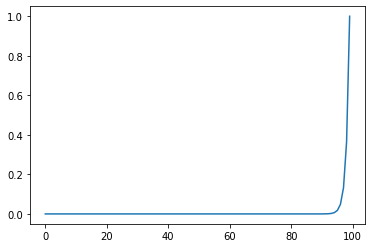

In [41]:
plt.plot(u(np.linspace(1, 2, num = 100), k = .01, beta = 1, L = 2))

In [44]:
def advection_diffusion(beta, 
                        k,
                        order,
                        mesh_refinement,
                        space_dim = 2,
                        L = 1.0,
                        B = 1.0,
                        r_border_refinements = 0,
                        r = Constant(0),
                        fileio = 'pvd',
                        dir_ = './results',
                        do_plot = False
                       ):
 
    if not os.path.exists(dir_):
        os.mkdir(dir_)

    if(space_dim == 2):
       domain = Rectangle(Point(0.0,0.0), Point(L,B))
    else:
       sys.exit("space_dim.eq.3 not implemented")
       
    # Calculo da camada limite para o refinamento
    L_hcamadalimite = L - k/np.sqrt(beta[0]^2+beta[1]^2)

    # Thermal conductivity
    #k = 1.0
    kappa = Constant(k)

    # Convection velocity field
    beta = Constant(beta)

    #### IO setup
    Pk = FiniteElement("Lagrange", 'triangle', order)

    ufile_pvd  = File(dir_+f'/temperatureO{order}mr{mesh_refinement}br{r_border_refinements}.pvd')
    domfile_pvd = File(dir_+f"/auxfuncO{order}mr{mesh_refinement}br{r_border_refinements}.pvd")

    # Order of finite elements space
    startTime = datetime.now()
    print(f'\n   ::> Begin computations for order {order} and refinement {mesh_refinement}')

    #### Mesh generation
    mesh = generate_mesh(domain, mesh_refinement)
    
        
    ### Dirichlet boundary conditions
    class Left(SubDomain):
        def inside(self, x, on_boundary):
            return (on_boundary and near(x[0],0))
    class Right(SubDomain):
        def inside(self, x, on_boundary):
            return (on_boundary and near(x[0],L))

    left    = Left()
    right   = Right()

    if r_border_refinements > 0:
      for i in range(r_border_refinements):
        cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
        cell_markers.set_all(False)
        for cell in cells(mesh):
          vts = cell.get_vertex_coordinates()
          max_x = max(vts[0],vts[2],vts[4])
          if(max_x>=(L_hcamadalimite)):
            cell_markers[cell] = True
        mesh = refine(mesh, cell_markers)
    
    print("    |-Mesh done")
    print("    |--Number of vertices = " + str(mesh.num_vertices()))
    print("    |--Number of cells = " + str(mesh.num_cells()))
    print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

    
    # Finite element space
    W = FunctionSpace(mesh, Pk)
    print("    |--Total number of unknowns = %d" % (W.dim()))
    
    
    ### Variational formulation: Poisson problem
    u = TrialFunction(W)
    v = TestFunction(W)

    funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
    dx = Measure("dx")(subdomain_data=funcdom)

    R = -kappa*grad(u) + inner(beta, grad(u))
    tk = lambda k : (4*kappa)/
    
    f = Constant(0)
    a = inner(kappa*grad(u), grad(v))*dx + v*inner(beta,grad(u))*dx
    LL = f*v*dx

    bcleft  = DirichletBC(W, Constant(0), left)
    bcright = DirichletBC(W, Constant(1), right)
    
    ### Solution
    w = Function(W)

    # solver.solve()
    solve(a + r == LL, w, [bcleft, bcright])

    ####### IO
    ufile_pvd << w
    domfile_pvd << funcdom
    
    if do_plot:
        plt.figure(figsize=(10,10))
        plot(mesh,linewidth=.1)
        c = plot(w, wireframe=True, title=f'Solution')
        plt.colorbar(c)
        plt.show()
    
    return w, mesh

In [45]:
k = .001
r_border_refinements = 4

(w, mesh) = advection_diffusion(beta = (1,0), 
                                k = k, 
                                order = 3, 
                                mesh_refinement = 40, 
                                L = 2, 
                                r_border_refinements = r_border_refinements) 

plt.figure(figsize=(20,20))
#plot(mesh,linewidth=.1)
c = plot(w, wireframe=True, title=f'Solution for k = {k}, border refinement = {r_border_refinements}')
#plt.colorbar(c)
plt.show()


   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 4472
    |--Number of cells = 8261
    |--Cell size hmax,hmin = 0.0503 0.00195
    |--Total number of unknowns = 38197


TypeError: unsupported operand type(s) for +: 'Form' and 'Constant'